# **Cell 1 — Mount Drive & set project paths**

* Why: makes the notebook reproducible; every later cell uses these paths.
* Expect: a Drive prompt, then the path string.
* Watch-outs: if you see “Permission denied,” re-run the mount line.

---




In [1]:
# Mount Google Drive so we can read/write files under /MyDrive
from google.colab import drive
drive.mount('/content/drive')

# Point to your project root (update only if you used a different folder name)
PROJECT_ROOT = '/content/drive/MyDrive/restaurant-turnover'

# Handy paths
from pathlib import Path
PR = Path(PROJECT_ROOT)
DATA_RAW  = PR/'data'/'raw'
DATA_PROC = PR/'data'/'processed'
OUT_MODELS = PR/'models'
OUT_SUBS   = PR/'outputs'/'submissions'

for p in [DATA_RAW, DATA_PROC, OUT_MODELS, OUT_SUBS]:
    p.mkdir(parents=True, exist_ok=True)

PROJECT_ROOT


Mounted at /content/drive


'/content/drive/MyDrive/restaurant-turnover'

# **Cell 2 — Load train/test (CSV → Parquet cache)**

* Why: Parquet loads faster and preserves dtypes.
* xpect: shapes like (3493, 34) and (500, 33).
* Watch-outs: if CSV not found, confirm your files are in data/raw.

In [2]:
import pandas as pd

TRAIN_CSV = DATA_RAW/'Train_dataset_.csv'
TEST_CSV  = DATA_RAW/'Test_dataset_.csv'
TRAIN_PQ  = DATA_PROC/'train.parquet'
TEST_PQ   = DATA_PROC/'test.parquet'

if TRAIN_PQ.exists() and TEST_PQ.exists():
    train = pd.read_parquet(TRAIN_PQ)
    test  = pd.read_parquet(TEST_PQ)
else:
    train = pd.read_csv(TRAIN_CSV)
    test  = pd.read_csv(TEST_CSV)
    train.to_parquet(TRAIN_PQ, index=False)
    test.to_parquet(TEST_PQ, index=False)

train.shape, test.shape, list(train.columns)[:5]


((3493, 34),
 (500, 33),
 ['Registration Number',
  'Annual Turnover',
  'Cuisine',
  'City',
  'Restaurant Location'])

# **Cell 3 — Schema guardrails (ID, target, uniqueness)**

* Why: prevents accidental leakage or broken submissions later.
* Expect: “✅ Schema OK…”.
* Watch-outs: if an assert trips, stop—share the message.

In [3]:
ID_COL, TARGET = "Registration Number", "Annual Turnover"

assert ID_COL in train.columns and ID_COL in test.columns, "Missing ID column"
assert TARGET in train.columns and TARGET not in test.columns, "Target should be only in train"

assert train[ID_COL].is_unique, "Duplicate IDs in train"
assert test[ID_COL].is_unique,  "Duplicate IDs in test"

print("✅ Schema OK. Rows:", len(train), len(test))


✅ Schema OK. Rows: 3493 500


# **Cell 4 — Quick type inventory & basic missingness**

* Why: guides imputation/encoding choices.
* Expect: the columns with most missing near the top.
* Watch-outs: none—just scanning.

In [4]:
num_cols_raw = train.select_dtypes(include='number').columns.tolist()
cat_cols_raw = train.select_dtypes(include=['object','category']).columns.tolist()

print("Numeric:", len(num_cols_raw), "| Categorical:", len(cat_cols_raw))
train.isna().mean().sort_values(ascending=False).head(10)


Numeric: 27 | Categorical: 7


,0
Live Sports Rating,0.941311
Value Deals Rating,0.774979
Comedy Gigs Rating,0.710850
Live Music Rating,0.219009
Overall Restaurant Rating,0.060693
Facebook Popularity Quotient,0.028342
Instagram Popularity Quotient,0.016032
Resturant Tier,0.014028
Ambience,0.007157
Registration Number,0.000000


# **Cell 5 — Branch clean copies (keep raw intact)**

* Why: all cleanup happens on *_clean, preserving earlier EDA for reference.
* Expect: same shapes as raw.
* Watch-outs: none.

In [5]:
train_raw = train.copy()
test_raw  = test.copy()

train_clean = train_raw.copy()
test_clean  = test_raw.copy()

print("Branched. Clean shapes:", train_clean.shape, test_clean.shape)


Branched. Clean shapes: (3493, 34) (500, 33)


# **Cell 6 — Standardize column names (typos) & City sentinel**

* Why: keeps train/test aligned; avoids a phantom category.
* Expect: “Unknown” appears in City counts if present.
* Watch-outs: typo might not exist—no problem.

In [6]:
# Fix known typo if present
rename_map = {"Endoresed By": "Endorsed By"}
train_clean.rename(columns=rename_map, inplace=True)
test_clean.rename(columns=rename_map, inplace=True)

# Replace City sentinel "-1" with explicit category "Unknown"
if "City" in train_clean.columns:
    for df in (train_clean, test_clean):
        df["City"] = df["City"].replace({"-1": "Unknown"})

print("Renames done. Example City values:", train_clean.get("City", pd.Series()).value_counts().head(5))


Renames done. Example City values: City
Bangalore    553
Unknown      396
Noida        324
Hyderabad    295
Pune         262
Name: count, dtype: int64


# **Cell 7 — Parse dates (day-first) & make date features**

* Why: models learn from age/seasonality, not raw date strings.
* Expect: reasonable stats (Age_days positive, month 1–12, dow 0–6).
* Watch-outs: if lots of NaT, earlier formats were odd; we already used dayfirst=True.

In [7]:
import pandas as pd

DATE_COL = "Opening Day of Restaurant"
if DATE_COL in train_clean.columns:
    for df in (train_clean, test_clean):
        df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce", dayfirst=True)
    anchor = pd.to_datetime(train_clean[DATE_COL]).max()

    for df in (train_clean, test_clean):
        df["Age_days"]   = (anchor - df[DATE_COL]).dt.days
        df["Open_month"] = df[DATE_COL].dt.month
        df["Open_dow"]   = df[DATE_COL].dt.dayofweek

print(train_clean[["Age_days","Open_month","Open_dow"]].describe().T)


             count         mean         std  min     25%     50%     75%  \
Age_days    3493.0  2365.305754  640.424371  0.0  1904.0  2275.0  2752.0   
Open_month  3493.0     6.622960    3.357918  1.0     4.0     7.0     9.0   
Open_dow    3493.0     2.982823    2.004360  0.0     1.0     3.0     5.0   

               max  
Age_days    7149.0  
Open_month    12.0  
Open_dow       6.0  


# **Cell 8 — Ratings: missing flags + median impute**

* Why: missing often means “feature absent” (useful signal); median is stable.
* Expect: non-zero count of flags.
* Watch-outs: none; median handles skew.

In [8]:
from sklearn.impute import SimpleImputer
rating_cols = [c for c in train_clean.columns if "Rating" in c and c != TARGET]

# informative missingness flags
for c in rating_cols:
    train_clean[f"{c}__isna"] = train_clean[c].isna().astype(int)
    test_clean[f"{c}__isna"]  = test_clean[c].isna().astype(int)

# robust numeric impute
if rating_cols:
    imp = SimpleImputer(strategy="median")
    train_clean[rating_cols] = imp.fit_transform(train_clean[rating_cols])
    test_clean[rating_cols]  = imp.transform(test_clean[rating_cols])

print("Added flags:", len([c for c in train_clean.columns if c.endswith("__isna")]))


Added flags: 8


# **Cell 9 — Categorical split by cardinality**

* Why: one-hot small sets; encode large sets compactly.
* Expect: a handful of high-card (e.g., City, Theme).
* Watch-outs: if a numeric field was misread as object, we’ll catch it later.

In [9]:
# Identify cats (post fixes)
cat_cols = train_clean.select_dtypes(include=['object','category']).columns.tolist()
cat_cols = [c for c in cat_cols if c not in [ID_COL, TARGET]]

low_card  = [c for c in cat_cols if train_clean[c].nunique(dropna=True) <= 30]
high_card = [c for c in cat_cols if train_clean[c].nunique(dropna=True) > 30]

print("Low-card:", len(low_card), low_card[:8])
print("High-card:", len(high_card), high_card[:8])


Low-card: 4 ['Cuisine', 'Restaurant Location', 'Endorsed By', 'Restaurant Type']
High-card: 2 ['City', 'Restaurant Theme']


# **Cell 10 — Build model matrices (one-hot low; frequency-encode high)**

* Why: creates a numeric matrix for tree models; log1p(tgt) tames skew.
* Expect: same column count for train/test.
* Watch-outs: we’ll sanitize names next (LightGBM quirk).

In [10]:
import pandas as pd
import numpy as np

# one-hot for low-card
train_oh = pd.get_dummies(train_clean[low_card], dummy_na=True) if low_card else pd.DataFrame(index=train_clean.index)
test_oh  = pd.get_dummies(test_clean[low_card],  dummy_na=True) if low_card else pd.DataFrame(index=test_clean.index)
if not (train_oh.empty and test_oh.empty):
    train_oh, test_oh = train_oh.align(test_oh, join="outer", axis=1, fill_value=0)

# frequency encoding for high-card
def freq_encode(s: pd.Series) -> pd.Series:
    freq = s.value_counts(normalize=True)
    return s.map(freq)

for c in high_card:
    train_clean[c+"_freq"] = freq_encode(train_clean[c])
    test_clean[c+"_freq"]  = freq_encode(test_clean[c]).fillna(0)

# numeric base (incl. date feats, ratings, flags), dropping ID/TARGET
num_cols = [c for c in train_clean.select_dtypes(include='number').columns if c not in [ID_COL, TARGET]]

X_train = pd.concat([train_clean[num_cols], train_oh,
                     train_clean[[c+"_freq" for c in high_card]] if high_card else pd.DataFrame(index=train_clean.index)], axis=1)
X_test  = pd.concat([test_clean[[c for c in num_cols if c in test_clean.columns]], test_oh,
                     test_clean[[c+"_freq" for c in high_card if c+"_freq" in test_clean.columns]] if high_card else pd.DataFrame(index=test_clean.index)], axis=1)

y_log = np.log1p(train_clean[TARGET]).reset_index(drop=True)

X_train.shape, X_test.shape


((3493, 73), (500, 73))

# **Cell 11 — Sanitize column names & collapse duplicates**

* Why: LightGBM rejects funky/duplicate names; we remove that risk.
* Expect: zero NaNs after fill; identical shapes.
* Watch-outs: if NaNs > 0, we’ll fill with medians—but usually 0 now.

In [11]:
import re
from collections import defaultdict
import pandas as pd
import numpy as np

def sanitize_token(s: str) -> str:
    s = re.sub(r'[^0-9A-Za-z_]+', '_', str(s))
    s = re.sub(r'_+', '_', s).strip('_')
    return s or "col"

def sanitize_columns(df: pd.DataFrame) -> pd.DataFrame:
    base = [sanitize_token(c) for c in df.columns]
    # de-dup names
    seen = {}; final = []
    for b in base:
        if b in seen:
            seen[b] += 1
            final.append(f"{b}__{seen[b]}")
        else:
            seen[b] = 0
            final.append(b)
    return df.set_axis(final, axis=1)

def collapse_duplicate_columns(df: pd.DataFrame) -> pd.DataFrame:
    groups = defaultdict(list)
    for i, c in enumerate(df.columns): groups[c].append(i)
    new_df = pd.DataFrame(index=df.index)
    for name, idxs in groups.items():
        block = df.iloc[:, idxs]
        new_df[name] = block.iloc[:,0] if block.shape[1]==1 else block.mean(axis=1)
    return new_df

X_train = collapse_duplicate_columns(sanitize_columns(X_train)).astype('float32')
X_test  = collapse_duplicate_columns(sanitize_columns(X_test)).astype('float32')
X_train, X_test = X_train.align(X_test, join='outer', axis=1, fill_value=0.0)

print("✅ names sanitized. Shapes:", X_train.shape, X_test.shape)
print("NaNs in X_train:", int(X_train.isna().sum().sum()))


✅ names sanitized. Shapes: (3493, 73) (500, 73)
NaNs in X_train: 229


# **Cell 12 — Install LightGBM (once per runtime)**

* Why: Colab sometimes lacks it by default.
* Expect: quiet install.
* Watch-outs: if you restart, re-run this.

In [12]:
!pip -q install lightgbm


# **Cell 13 — Cross-validation (KFold) with early stopping**

* Why: honest quality check vs the baseline (~21.5M).
* Expect: mean RMSE below baseline (likely ~20–21M with this simple setup).

Watch-outs:
1. early_stopping_rounds not recognized → we’re using callbacks already (safe).
2. NaN error → go back to Cell 11 and ensure NaNs are 0; if not, fill with train medians.

In [13]:
import numpy as np
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor, early_stopping, log_evaluation

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores, best_iters = [], []

for tr, va in kf.split(X_train):
    model = LGBMRegressor(
        n_estimators=6000, learning_rate=0.02,
        num_leaves=31, min_child_samples=40,
        subsample=0.8, colsample_bytree=0.8,
        reg_lambda=1.0, random_state=42, n_jobs=-1
    )
    model.fit(
        X_train.iloc[tr], y_log.iloc[tr],
        eval_set=[(X_train.iloc[va], y_log.iloc[va])],
        eval_metric="rmse",
        callbacks=[early_stopping(200), log_evaluation(100)]
    )
    best_iters.append(model.best_iteration_)
    pred_va = np.expm1(model.predict(X_train.iloc[va], num_iteration=model.best_iteration_))
    score = rmse(np.expm1(y_log.iloc[va]), pred_va)
    cv_scores.append(score)
    print(f"Fold | best_iter={model.best_iteration_:>4} | RMSE: {score:,.0f}")

print("CV RMSE mean:", f"{np.mean(cv_scores):,.0f}",
      "| std:", f"{np.std(cv_scores):,.0f}",
      "| avg best_iter:", int(np.mean(best_iters)))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 2794, number of used features: 59
[LightGBM] [Info] Start training from score 17.086072
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 0.473522	valid_0's l2: 0.224223
[200]	valid_0's rmse: 0.464941	valid_0's l2: 0.21617
[300]	valid_0's rmse: 0.463465	valid_0's l2: 0.2148
[400]	valid_0's rmse: 0.463957	valid_0's l2: 0.215256
Early stopping, best iteration is:
[277]	valid_0's rmse: 0.463179	valid_0's l2: 0.214534
Fold | best_iter= 277 | RMSE: 19,296,476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough

# **Cell 14 — Train final model & predict test**

* Why: fit once on all data using a sensible tree count.
* Expect: length 500; values similar order of magnitude as the target.
* Watch-outs: if wildly tiny/huge, we investigate features.

In [14]:
from lightgbm import LGBMRegressor
best_iter = int(np.mean(best_iters)) if best_iters else 1200

final = LGBMRegressor(
    n_estimators=best_iter, learning_rate=0.02,
    num_leaves=31, min_child_samples=40,
    subsample=0.8, colsample_bytree=0.8,
    reg_lambda=1.0, random_state=42, n_jobs=-1
).fit(X_train, y_log)

test_pred = np.expm1(final.predict(X_test))
len(test_pred), test_pred[:5]


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1106
[LightGBM] [Info] Number of data points in the train set: 3493, number of used features: 63
[LightGBM] [Info] Start training from score 17.087897


(500,
 array([23290084.44039058, 30517262.75302121, 26460906.41322152,
        41224087.10638832, 41213043.40954559]))

# **Cell 15 — Build & save submission (format-checked)**

* Why: exact required two columns; 500 rows.
* Expect: a CSV path printed.
* Watch-outs: assertion messages are your friend if something’s off.

In [15]:
import pandas as pd
from pathlib import Path

sub = test_clean[[ID_COL]].copy()
sub["Annual Turnover"] = test_pred

# Save (overwrite okay while iterating)
OUT_SUBS.mkdir(parents=True, exist_ok=True)
out_path = OUT_SUBS/"submission_lgbm_step1.csv"
sub.to_csv(out_path, index=False)

# Hard checks per hackathon spec
assert sub.columns.tolist() == ["Registration Number","Annual Turnover"]
assert len(sub) == 500
assert sub[ID_COL].is_unique

print("✅ Submission saved:", out_path)
sub.head()


✅ Submission saved: /content/drive/MyDrive/restaurant-turnover/outputs/submissions/submission_lgbm_step1.csv


,Registration Number,Annual Turnover
0,20001,2.329008e+07
1,20002,3.051726e+07
2,20003,2.646091e+07
3,20004,4.122409e+07
4,20005,4.121304e+07


# **Cell 16 — Feature importance (sanity check)**

* Why: confirm the model leans on sensible signals (age, tiers, ratings, party-hub, city/theme encodings).
* Watch for: anything ID-ish near the top (bad); all zeros (means something went wrong earlier).

In [16]:
import pandas as pd

imp = pd.Series(final.feature_importances_, index=X_train.columns).sort_values(ascending=False)
top20 = imp.head(20).to_frame("gain")
display(top20)


,gain
Age_days,880
Instagram_Popularity_Quotient,672
Facebook_Popularity_Quotient,671
City_freq,586
Open_month,252
Ambience,237
Comfortablility,235
Order_Wait_Time,220
Hygiene_Rating,220
Live_Music_Rating,219


# **Cell 17 — Scale sanity: target vs predictions**

* Why: quick visual check that predictions live in the right ballpark.
* Watch for: predictions all crammed into a tiny range or orders of magnitude off.

Train target summary:


,Annual Turnover
count,3.493000e+03
mean,3.072571e+07
std,2.165125e+07
min,3.500000e+06
1%,7.000000e+06
5%,1.000000e+07
50%,3.000000e+07
95%,5.700000e+07
99%,1.000000e+08
max,4.000000e+08


Test prediction summary:


,Annual Turnover
count,5.000000e+02
mean,2.706277e+07
std,7.735726e+06
min,1.267207e+07
1%,1.352031e+07
5%,1.620183e+07
50%,2.598830e+07
95%,4.067734e+07
99%,4.780490e+07
max,5.479786e+07


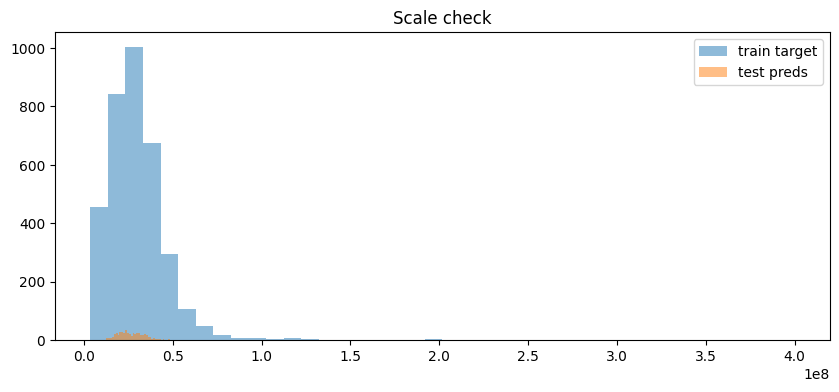

In [17]:
import numpy as np, matplotlib.pyplot as plt

print("Train target summary:")
display(train_clean["Annual Turnover"].describe(percentiles=[.01,.05,.5,.95,.99]))

print("Test prediction summary:")
display(pd.Series(test_pred, name="Annual Turnover").describe(percentiles=[.01,.05,.5,.95,.99]))

plt.figure(figsize=(10,4))
plt.hist(train_clean["Annual Turnover"], bins=40, alpha=0.5, label="train target")
plt.hist(test_pred, bins=40, alpha=0.5, label="test preds")
plt.title("Scale check"); plt.legend(); plt.show()


# **Cell 18 — K-Fold target encoding for City + rebuild matrices + CV**

* Why: City is high-card and drift-prone. CV-safe target encoding often adds signal beyond frequency counts.
* Expect: CV mean a bit below your plain LGBM baseline (ideally closer to your CatBoost ~19.8M).

Watch-outs:
* If you see ValueError: ... not found, double-check column name spelling.
* If NaN errors appear, ensure Cell 11 (sanitize/collapse) was run earlier in this fresh notebook too.

In [18]:
# --- KFold target encoding for 'City' (leak-safe) ---
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np

TARGET = "Annual Turnover"
ID_COL = "Registration Number"

def kfold_target_encode(train_df, test_df, col, target, n_splits=5, smoothing=200, seed=42):
    """Create col__te using KFold means with smoothing (no leakage)."""
    tr = train_df[[col, target]].copy()
    global_mean = tr[target].mean()

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    oof = pd.Series(index=train_df.index, dtype=float)

    for tr_idx, va_idx in kf.split(tr):
        tr_fold = tr.iloc[tr_idx]
        stats = tr_fold.groupby(col)[target].agg(['mean','count'])
        stats['te'] = (stats['count']*stats['mean'] + smoothing*global_mean) / (stats['count'] + smoothing)
        oof.iloc[va_idx] = tr.iloc[va_idx][col].map(stats['te']).fillna(global_mean)

    stats = tr.groupby(col)[target].agg(['mean','count'])
    stats['te'] = (stats['count']*stats['mean'] + smoothing*global_mean) / (stats['count'] + smoothing)
    test_te = test_df[col].map(stats['te']).fillna(global_mean)

    train_df[f"{col}__te"] = oof.values
    test_df[f"{col}__te"]  = test_te.values
    return train_df, test_df

# 1) Make TE copies and encode City
train_te = train_clean.copy()
test_te  = test_clean.copy()
if "City" in train_te.columns:
    train_te, test_te = kfold_target_encode(train_te, test_te, "City", TARGET, n_splits=5, smoothing=200)
else:
    raise ValueError("Column 'City' not found for target encoding.")

# 2) Build matrices: numerics (+ new City__te), one-hot low-card categoricals
cat_cols = train_te.select_dtypes(include=['object','category']).columns.tolist()
cat_cols = [c for c in cat_cols if c not in [ID_COL, TARGET]]

low_card  = [c for c in cat_cols if train_te[c].nunique(dropna=True) <= 30]

train_oh = pd.get_dummies(train_te[low_card], dummy_na=True) if low_card else pd.DataFrame(index=train_te.index)
test_oh  = pd.get_dummies(test_te[low_card],  dummy_na=True) if low_card else pd.DataFrame(index=test_te.index)
if not (train_oh.empty and test_oh.empty):
    train_oh, test_oh = train_oh.align(test_oh, join="outer", axis=1, fill_value=0)

num_cols = [c for c in train_te.select_dtypes(include='number').columns if c not in [ID_COL, TARGET]]

X_city = pd.concat([train_te[num_cols], train_oh, train_te[["City__te"]]], axis=1)
T_city = pd.concat([test_te[[c for c in num_cols if c in test_te.columns]], test_oh, test_te[["City__te"]]], axis=1)

# 3) Sanitize names + collapse duplicates (functions defined earlier in Cell 11)
X_city  = collapse_duplicate_columns(sanitize_columns(X_city)).astype("float32")
T_city  = collapse_duplicate_columns(sanitize_columns(T_city)).astype("float32")
X_city, T_city = X_city.align(T_city, join="outer", axis=1, fill_value=0.0)

# 4) CV with LightGBM on log target
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor, early_stopping, log_evaluation

y_log_city = np.log1p(train_te[TARGET]).reset_index(drop=True)

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores, best_iters = [], []

for tr, va in kf.split(X_city):
    model = LGBMRegressor(
        n_estimators=6000, learning_rate=0.02,
        num_leaves=31, min_child_samples=40,
        subsample=0.8, colsample_bytree=0.8,
        reg_lambda=1.0, random_state=42, n_jobs=-1
    )
    model.fit(
        X_city.iloc[tr], y_log_city.iloc[tr],
        eval_set=[(X_city.iloc[va], y_log_city.iloc[va])],
        eval_metric="rmse",
        callbacks=[early_stopping(200), log_evaluation(100)]
    )
    pred = np.expm1(model.predict(X_city.iloc[va], num_iteration=model.best_iteration_))
    score = rmse(np.expm1(y_log_city.iloc[va]), pred)
    cv_scores.append(score); best_iters.append(model.best_iteration_)
    print(f"Fold | best_iter={model.best_iteration_:>4} | RMSE: {score:,.0f}")

print("LGBM + City__te | CV mean:", f"{np.mean(cv_scores):,.0f}",
      "| std:", f"{np.std(cv_scores):,.0f}",
      "| avg best_iter:", int(np.mean(best_iters)))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1358
[LightGBM] [Info] Number of data points in the train set: 2794, number of used features: 59
[LightGBM] [Info] Start training from score 17.086072
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 0.47017	valid_0's l2: 0.22106
[200]	valid_0's rmse: 0.461495	valid_0's l2: 0.212977
[300]	valid_0's rmse: 0.460546	valid_0's l2: 0.212102
[400]	valid_0's rmse: 0.461148	valid_0's l2: 0.212658
Early stopping, best iteration is:
[273]	valid_0's rmse: 0.460247	valid_0's l2: 0.211827
Fold | best_iter= 273 | RMSE: 19,324,831
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

# **Cell 19 — Train final on City-TE matrix + write a new submission**

* Why: produce a submission from the improved feature set.
* Expect: file saved under outputs/submissions/.
* Watch-outs: column order/row count assertions guard the required format.

In [19]:
from lightgbm import LGBMRegressor
from pathlib import Path
import pandas as pd
best_iter = int(np.mean(best_iters)) if best_iters else 1200

final_city = LGBMRegressor(
    n_estimators=best_iter, learning_rate=0.02,
    num_leaves=31, min_child_samples=40,
    subsample=0.8, colsample_bytree=0.8,
    reg_lambda=1.0, random_state=42, n_jobs=-1
).fit(X_city, y_log_city)

test_pred_city = np.expm1(final_city.predict(T_city))

sub_city = test_clean[["Registration Number"]].copy()
sub_city["Annual Turnover"] = test_pred_city

out_path = OUT_SUBS/"submission_lgbm_cityTE.csv"
sub_city.to_csv(out_path, index=False)

# required checks
assert sub_city.columns.tolist() == ["Registration Number","Annual Turnover"]
assert len(sub_city) == 500 and sub_city["Registration Number"].is_unique
print("✅ Saved:", out_path)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1512
[LightGBM] [Info] Number of data points in the train set: 3493, number of used features: 63
[LightGBM] [Info] Start training from score 17.087897
✅ Saved: /content/drive/MyDrive/restaurant-turnover/outputs/submissions/submission_lgbm_cityTE.csv


# **Cell 20 — Add Restaurant Theme target encoding, rebuild, and CV**

* What this is doing & what to watch: We add one more leak-safe target-encoded column: Restaurant Theme__te, alongside City__te.

* Expect the CV mean to tick down (even a small drop is a win).
* If an error mentions missing column names, double-check "Restaurant Theme" spelling/case.

In [20]:
# --- KFold target encoding for 'Restaurant Theme' (leak-safe) ---
from sklearn.model_selection import KFold
import pandas as pd, numpy as np

def kfold_target_encode(train_df, test_df, col, target, n_splits=5, smoothing=200, seed=42):
    tr = train_df[[col, target]].copy()
    global_mean = tr[target].mean()
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    oof = pd.Series(index=train_df.index, dtype=float)

    for tr_idx, va_idx in kf.split(tr):
        tr_fold = tr.iloc[tr_idx]
        stats = tr_fold.groupby(col)[target].agg(['mean','count'])
        stats['te'] = (stats['count']*stats['mean'] + smoothing*global_mean) / (stats['count'] + smoothing)
        oof.iloc[va_idx] = tr.iloc[va_idx][col].map(stats['te']).fillna(global_mean)

    stats = tr.groupby(col)[target].agg(['mean','count'])
    stats['te'] = (stats['count']*stats['mean'] + smoothing*global_mean) / (stats['count'] + smoothing)
    test_te = test_df[col].map(stats['te']).fillna(global_mean)

    train_df[f"{col}__te"] = oof.values
    test_df[f"{col}__te"]  = test_te.values
    return train_df, test_df

# 1) Start from your *existing* City-TE copies so we keep City__te
train_te2 = train_te.copy()
test_te2  = test_te.copy()

# 2) Encode Restaurant Theme if present
col_theme = "Restaurant Theme"
assert col_theme in train_te2.columns, f"'{col_theme}' not found"
train_te2, test_te2 = kfold_target_encode(train_te2, test_te2, col_theme, TARGET, n_splits=5, smoothing=200)

# 3) Rebuild matrices: numerics + one-hot(low-card) + both TE columns
ID_COL, TARGET = "Registration Number", "Annual Turnover"
cat_cols = train_te2.select_dtypes(include=['object','category']).columns.tolist()
cat_cols = [c for c in cat_cols if c not in [ID_COL, TARGET]]
low_card = [c for c in cat_cols if train_te2[c].nunique(dropna=True) <= 30]

train_oh = pd.get_dummies(train_te2[low_card], dummy_na=True) if low_card else pd.DataFrame(index=train_te2.index)
test_oh  = pd.get_dummies(test_te2[low_card],  dummy_na=True) if low_card else pd.DataFrame(index=test_te2.index)
if not (train_oh.empty and test_oh.empty):
    train_oh, test_oh = train_oh.align(test_oh, join="outer", axis=1, fill_value=0)

num_cols = [c for c in train_te2.select_dtypes(include='number').columns if c not in [ID_COL, TARGET]]
te_cols  = [c for c in train_te2.columns if c.endswith("__te")]  # should include City__te and Restaurant Theme__te

X_theme = pd.concat([train_te2[num_cols], train_oh, train_te2[te_cols]], axis=1)
T_theme = pd.concat([test_te2[[c for c in num_cols if c in test_te2.columns]], test_oh, test_te2[te_cols]], axis=1)

# 4) Sanitize names + collapse dups (reuse your helpers)
X_theme = collapse_duplicate_columns(sanitize_columns(X_theme)).astype("float32")
T_theme = collapse_duplicate_columns(sanitize_columns(T_theme)).astype("float32")
X_theme, T_theme = X_theme.align(T_theme, join="outer", axis=1, fill_value=0.0)

# 5) CV with LightGBM on log-target
from lightgbm import LGBMRegressor, early_stopping, log_evaluation

y_log_theme = np.log1p(train_te2[TARGET]).reset_index(drop=True)

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores, best_iters = [], []

for tr, va in kf.split(X_theme):
    model = LGBMRegressor(
        n_estimators=6000, learning_rate=0.02,
        num_leaves=31, min_child_samples=40,
        subsample=0.8, colsample_bytree=0.8,
        reg_lambda=1.0, random_state=42, n_jobs=-1
    )
    model.fit(
        X_theme.iloc[tr], y_log_theme.iloc[tr],
        eval_set=[(X_theme.iloc[va], y_log_theme.iloc[va])],
        eval_metric="rmse",
        callbacks=[early_stopping(200), log_evaluation(100)]
    )
    pred = np.expm1(model.predict(X_theme.iloc[va], num_iteration=model.best_iteration_))
    score = rmse(np.expm1(y_log_theme.iloc[va]), pred)
    cv_scores.append(score); best_iters.append(model.best_iteration_)
    print(f"Fold | best_iter={model.best_iteration_:>4} | RMSE: {score:,.0f}")

print("LGBM + City__te + Theme__te | CV mean:", f"{np.mean(cv_scores):,.0f}",
      "| std:", f"{np.std(cv_scores):,.0f}",
      "| avg best_iter:", int(np.mean(best_iters)))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1450
[LightGBM] [Info] Number of data points in the train set: 2794, number of used features: 61
[LightGBM] [Info] Start training from score 17.086072
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 0.468565	valid_0's l2: 0.219553
[200]	valid_0's rmse: 0.458904	valid_0's l2: 0.210593
[300]	valid_0's rmse: 0.458929	valid_0's l2: 0.210616
[400]	valid_0's rmse: 0.45999	valid_0's l2: 0.211591
Early stopping, best iteration is:
[259]	valid_0's rmse: 0.458477	valid_0's l2: 0.210201
Fold | best_iter= 259 | RMSE: 19,210,036
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enou

# **Cell 21 — LGBM small tune (num_leaves↑, min_child_samples↓)**

* Why: more leaves lets the tree capture richer category interactions; stronger L2 keeps variance in check.
* Expect: a modest drop below ~20.06M.
* Watch-outs: if CV worsens or overfits (very low train, higher val), we’ll roll back and add one more TE column next.

In [21]:
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
import numpy as np

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_tuned, best_iters_tuned = [], []

for tr, va in kf.split(X_theme):
    model = LGBMRegressor(
        n_estimators=6000,
        learning_rate=0.02,
        num_leaves=63,           # wider than 31
        min_child_samples=20,    # allow finer splits
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=5.0,          # a bit more L2 to keep it stable
        random_state=42,
        n_jobs=-1
    )
    model.fit(
        X_theme.iloc[tr], y_log_theme.iloc[tr],
        eval_set=[(X_theme.iloc[va], y_log_theme.iloc[va])],
        eval_metric="rmse",
        callbacks=[early_stopping(250), log_evaluation(100)]
    )
    pred = np.expm1(model.predict(X_theme.iloc[va], num_iteration=model.best_iteration_))
    score = rmse(np.expm1(y_log_theme.iloc[va]), pred)
    cv_tuned.append(score); best_iters_tuned.append(model.best_iteration_)
    print(f"Fold | best_iter={model.best_iteration_:>4} | RMSE: {score:,.0f}")

print("LGBM tuned CV mean:", f"{np.mean(cv_tuned):,.0f}",
      "| std:", f"{np.std(cv_tuned):,.0f}",
      "| avg best_iter:", int(np.mean(best_iters_tuned)))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1462
[LightGBM] [Info] Number of data points in the train set: 2794, number of used features: 67
[LightGBM] [Info] Start training from score 17.086072
Training until validation scores don't improve for 250 rounds
[100]	valid_0's rmse: 0.469587	valid_0's l2: 0.220512
[200]	valid_0's rmse: 0.462808	valid_0's l2: 0.214191
[300]	valid_0's rmse: 0.462837	valid_0's l2: 0.214218
[400]	valid_0's rmse: 0.464311	valid_0's l2: 0.215585
[500]	valid_0's rmse: 0.465167	valid_0's l2: 0.216381
Early stopping, best iteration is:
[266]	valid_0's rmse: 0.462468	valid_0's l2: 0.213877
Fold | best_iter= 266 | RMSE: 19,478,410
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000853 seconds.
You can set `force_row_wise=

# **Cell 22 — Add Restaurant Type__te, rebuild matrices, and CV (baseline tree settings)**

* Why this step: Restaurant Type (if high-card) often carries business signal like format/price point. TE gives it a compact, leak-safe numeric representation.

* What to expect: CV mean nudges down again (even a small drop is good). If it rises or doesn’t move, we’ll keep City/Theme and skip Type.

* Watch-outs: if Restaurant Type has low cardinality (≤30), TE won’t help—one-hot is usually better. In that case, we can bail on TE for it and keep the previous matrix.

In [22]:
# 0) Check cardinality—only TE if it's truly high-card (>30 unique)
col_type = "Restaurant Type"
n_unique = train_clean[col_type].nunique(dropna=True) if col_type in train_clean.columns else 0
print(f"{col_type} uniques:", n_unique)
assert col_type in train_clean.columns, f"'{col_type}' not found"

# 1) Reuse the TE function (already defined earlier). Encode Restaurant Type in the copies that already have City__te and Theme__te.
train_te3 = train_te2.copy()
test_te3  = test_te2.copy()

train_te3, test_te3 = kfold_target_encode(train_te3, test_te3, col_type, TARGET, n_splits=5, smoothing=200)

# 2) Rebuild matrices: numerics + one-hot(low-card) + all __te columns
ID_COL, TARGET = "Registration Number", "Annual Turnover"
cat_cols = train_te3.select_dtypes(include=['object','category']).columns.tolist()
cat_cols = [c for c in cat_cols if c not in [ID_COL, TARGET]]
low_card = [c for c in cat_cols if train_te3[c].nunique(dropna=True) <= 30]

train_oh = pd.get_dummies(train_te3[low_card], dummy_na=True) if low_card else pd.DataFrame(index=train_te3.index)
test_oh  = pd.get_dummies(test_te3[low_card],  dummy_na=True) if low_card else pd.DataFrame(index=test_te3.index)
if not (train_oh.empty and test_oh.empty):
    train_oh, test_oh = train_oh.align(test_oh, join="outer", axis=1, fill_value=0)

num_cols = [c for c in train_te3.select_dtypes(include='number').columns if c not in [ID_COL, TARGET]]
te_cols  = [c for c in train_te3.columns if c.endswith("__te")]

X_te3 = pd.concat([train_te3[num_cols], train_oh, train_te3[te_cols]], axis=1)
T_te3 = pd.concat([test_te3[[c for c in num_cols if c in test_te3.columns]], test_oh, test_te3[te_cols]], axis=1)

# 3) Sanitize + collapse duplicates (reuse helpers)
X_te3 = collapse_duplicate_columns(sanitize_columns(X_te3)).astype("float32")
T_te3 = collapse_duplicate_columns(sanitize_columns(T_te3)).astype("float32")
X_te3, T_te3 = X_te3.align(T_te3, join="outer", axis=1, fill_value=0.0)

# 4) CV with *baseline* tree settings (no wider trees), on log-target
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
import numpy as np

y_log_te3 = np.log1p(train_te3[TARGET]).reset_index(drop=True)

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv3, best_iters3 = [], []

for tr, va in kf.split(X_te3):
    model = LGBMRegressor(
        n_estimators=6000, learning_rate=0.02,
        num_leaves=31, min_child_samples=40,
        subsample=0.8, colsample_bytree=0.8,
        reg_lambda=1.0, random_state=42, n_jobs=-1
    )
    model.fit(
        X_te3.iloc[tr], y_log_te3.iloc[tr],
        eval_set=[(X_te3.iloc[va], y_log_te3.iloc[va])],
        eval_metric="rmse",
        callbacks=[early_stopping(200), log_evaluation(100)]
    )
    pred = np.expm1(model.predict(X_te3.iloc[va], num_iteration=model.best_iteration_))
    score = rmse(np.expm1(y_log_te3.iloc[va]), pred)
    cv3.append(score); best_iters3.append(model.best_iteration_)
    print(f"Fold | best_iter={model.best_iteration_:>4} | RMSE: {score:,.0f}")

print("LGBM + City__te + Theme__te + Type__te | CV mean:",
      f"{np.mean(cv3):,.0f}", "| std:", f"{np.std(cv3):,.0f}",
      "| avg best_iter:", int(np.mean(best_iters3)))


Restaurant Type uniques: 4
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1476
[LightGBM] [Info] Number of data points in the train set: 2794, number of used features: 63
[LightGBM] [Info] Start training from score 17.086072
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 0.469298	valid_0's l2: 0.220241
[200]	valid_0's rmse: 0.460468	valid_0's l2: 0.212031
[300]	valid_0's rmse: 0.459982	valid_0's l2: 0.211584
[400]	valid_0's rmse: 0.460216	valid_0's l2: 0.211799
Early stopping, best iteration is:
[259]	valid_0's rmse: 0.459478	valid_0's l2: 0.21112
Fold | best_iter= 259 | RMSE: 19,246,980
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002783 seconds.
You can set `force_row_wise=true` to remove the overhead

# **Cell 23 — CatBoost (raw target) 5-fold CV + final test predictions**

* Why: CatBoost does leak-safe ordered encoding internally and often scores best on mixed tabular.
* Expect: CV ≈ your earlier CatBoost (~19–22M folds).
* Watch-outs: if you see a categorical index error, re-run earlier cells so train_clean/test_clean exist.

In [23]:
# CatBoost handles string categoricals + NaNs natively; use train_clean/test_clean directly.
!pip -q install catboost

import numpy as np, pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold

ID_COL, TARGET = "Registration Number", "Annual Turnover"

# Use numeric features we engineered (Age_days/Open_month/Open_dow, ratings, flags, etc.)
num_cols_cb = [c for c in train_clean.select_dtypes(include="number").columns if c not in [ID_COL, TARGET]]
# Keep raw string categoricals
cat_cols_cb = [c for c in train_clean.select_dtypes(include=["object","category"]).columns if c not in [ID_COL, TARGET]]

X_cb = train_clean[num_cols_cb + cat_cols_cb]
T_cb = test_clean[[c for c in num_cols_cb if c in test_clean.columns] + cat_cols_cb]
cat_idx = [X_cb.columns.get_loc(c) for c in cat_cols_cb]
y = train_clean[TARGET].values

# 5-fold CV (on raw y)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_cb = np.zeros(len(y))
cv_cb = []

for fold, (tr, va) in enumerate(kf.split(X_cb)):
    tr_pool = Pool(X_cb.iloc[tr], y[tr], cat_features=cat_idx)
    va_pool = Pool(X_cb.iloc[va], y[va], cat_features=cat_idx)
    cb = CatBoostRegressor(
        loss_function="RMSE",
        depth=6, learning_rate=0.05, l2_leaf_reg=3.0,
        iterations=10000, random_seed=42,
        od_type="Iter", od_wait=300, verbose=False
    )
    cb.fit(tr_pool, eval_set=va_pool, use_best_model=True)
    pred = cb.predict(va_pool)
    rmse = float(np.sqrt(np.mean((y[va] - pred)**2)))
    cv_cb.append(rmse); oof_cb[va] = pred
    print(f"CatBoost Fold {fold+1} RMSE: {rmse:,.0f}")

print("CatBoost CV mean:", f"{np.mean(cv_cb):,.0f}", "| std:", f"{np.std(cv_cb):,.0f}")

# Train final and predict test
full_pool = Pool(X_cb, y, cat_features=cat_idx)
final_cb = CatBoostRegressor(
    loss_function="RMSE",
    depth=6, learning_rate=0.05, l2_leaf_reg=3.0,
    iterations=int(np.mean([6000])) ,  # steady cap; OD will stop early
    random_seed=42, od_type="Iter", od_wait=300, verbose=False
).fit(full_pool)

test_pred_cb = final_cb.predict(Pool(T_cb, cat_features=cat_idx))

# quick format check (no file save yet)
len(test_pred_cb), test_pred_cb[:5]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00
CatBoost Fold 1 RMSE: 19,185,718
CatBoost Fold 2 RMSE: 22,324,500
CatBoost Fold 3 RMSE: 20,549,034
CatBoost Fold 4 RMSE: 15,022,714
CatBoost Fold 5 RMSE: 22,089,804
CatBoost CV mean: 19,834,354 | std: 2,659,747


(500,
 array([26173698.68894644, 43194924.788654  , 26062311.81925178,
        53786979.832003  , 33633493.44443369]))

# **Cell 24 — LGBM OOF on X_theme (City__te + Theme__te) for blending**

* Why: we need OOF for LGBM and CatBoost to learn blend weights that best fit the training target.
* Expect: CV ~20.0–20.1M (like before).
* Watch-outs: ensure you didn’t overwrite X_theme/T_theme.

In [24]:
# Reuse X_theme / y_log_theme from earlier (City__te + Theme__te build)
# Produce OOF on *original* target scale for a fair blend with CatBoost.

import numpy as np
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor, early_stopping

assert 'X_theme' in globals() and 'y_log_theme' in globals(), "Build X_theme/y_log_theme first."

kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_lgbm = np.zeros(len(y_log_theme))
cv_lgbm = []
best_iters = []

for tr, va in kf.split(X_theme):
    m = LGBMRegressor(
        n_estimators=6000, learning_rate=0.02,
        num_leaves=31, min_child_samples=40,
        subsample=0.8, colsample_bytree=0.8,
        reg_lambda=1.0, random_state=42, n_jobs=-1
    )
    m.fit(X_theme.iloc[tr], y_log_theme.iloc[tr],
          eval_set=[(X_theme.iloc[va], y_log_theme.iloc[va])],
          eval_metric="rmse",
          callbacks=[early_stopping(200)])
    best_iters.append(m.best_iteration_)
    pred = np.expm1(m.predict(X_theme.iloc[va], num_iteration=m.best_iteration_))
    true = np.expm1(y_log_theme.iloc[va])
    rmse = float(np.sqrt(np.mean((true - pred)**2)))
    cv_lgbm.append(rmse); oof_lgbm[va] = pred
    print(f"LGBM(TE) fold RMSE: {rmse:,.0f}")

print("LGBM(TE) CV mean:", f"{np.mean(cv_lgbm):,.0f}", "| std:", f"{np.std(cv_lgbm):,.0f}",
      "| avg best_iter:", int(np.mean(best_iters)))

# Train final on all rows and get test preds on T_theme
best_iter = int(np.mean(best_iters)) if best_iters else 1200
final_lgbm_theme = LGBMRegressor(
    n_estimators=best_iter, learning_rate=0.02,
    num_leaves=31, min_child_samples=40,
    subsample=0.8, colsample_bytree=0.8,
    reg_lambda=1.0, random_state=42, n_jobs=-1
).fit(X_theme, y_log_theme)

test_pred_lgbm_theme = np.expm1(final_lgbm_theme.predict(T_theme))
len(test_pred_lgbm_theme), test_pred_lgbm_theme[:5]


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1450
[LightGBM] [Info] Number of data points in the train set: 2794, number of used features: 61
[LightGBM] [Info] Start training from score 17.086072
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[259]	valid_0's rmse: 0.458477	valid_0's l2: 0.210201
LGBM(TE) fold RMSE: 19,210,036
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1454
[LightGBM] [Info] Number of data points in the train set: 2794, number of used features: 61
[LightGBM] [Info] Start training from score 17.080989
Traini

(500,
 array([25517575.99365398, 33602088.38557069, 28248723.35162798,
        40209359.28779216, 41295864.5349862 ]))

# **Cell 25 — Learn blend weights (Ridge) and write blended submission**

* Why: a learned blend usually beats either model alone (they make different mistakes).
* Expect: non-trivial weights (often ~0.5–0.8 on CatBoost), valid CSV saved.
* Watch-outs: if any variable is undefined, re-run Cells 23–24.

In [25]:
from sklearn.linear_model import RidgeCV, LinearRegression
import numpy as np, pandas as pd
from pathlib import Path

# Z = [CatBoost OOF, LGBM(TE) OOF]
Z = np.column_stack([oof_cb, oof_lgbm])
y_true = train_clean["Annual Turnover"].values

# 1) RidgeCV with strictly positive alphas
alphas = [0.1, 1.0, 3.0, 10.0, 30.0, 100.0]
ridge = RidgeCV(alphas=alphas, store_cv_values=False)
ridge.fit(Z, y_true)
w_ridge, b_ridge = ridge.coef_, ridge.intercept_
oof_blend_ridge = ridge.predict(Z)

def rmse(a, b):
    a = np.asarray(a); b = np.asarray(b);
    return float(np.sqrt(np.mean((a - b)**2)))

print(f"Ridge alphas tried: {alphas} | chosen alpha: {ridge.alpha_}")
print("OOF RMSEs — CB:", f"{rmse(y_true, oof_cb):,.0f}",
      "| LGBM(TE):", f"{rmse(y_true, oof_lgbm):,.0f}",
      "| Blend(Ridge):", f"{rmse(y_true, oof_blend_ridge):,.0f}")
print("Ridge weights:", w_ridge, "| intercept:", b_ridge)

# 2) (Optional) Unregularized LinearRegression for reference
lin = LinearRegression().fit(Z, y_true)
oof_blend_lin = lin.predict(Z)
print("Blend(Linear) OOF RMSE:", f"{rmse(y_true, oof_blend_lin):,.0f}",
      "| weights:", lin.coef_, "| intercept:", lin.intercept_)

# 3) Apply the Ridge blend to TEST predictions
Ztest = np.column_stack([test_pred_cb, test_pred_lgbm_theme])
blend_pred = ridge.predict(Ztest)

# Build submission
sub_blend = test_clean[["Registration Number"]].copy()
sub_blend["Annual Turnover"] = blend_pred

OUT_SUBS.mkdir(parents=True, exist_ok=True)
out_path = OUT_SUBS/"submission_blend_cb_lgbmTE.csv"
sub_blend.to_csv(out_path, index=False)

# required checks
assert sub_blend.columns.tolist() == ["Registration Number","Annual Turnover"]
assert len(sub_blend) == 500 and sub_blend["Registration Number"].is_unique
print("✅ Saved blended submission:", out_path)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


Ridge alphas tried: [0.1, 1.0, 3.0, 10.0, 30.0, 100.0] | chosen alpha: 10.0
OOF RMSEs — CB: 20,012,517 | LGBM(TE): 20,251,571 | Blend(Ridge): 84,305,112
Ridge weights: [4.20898438 7.79003906] | intercept: -310291050.884508
Blend(Linear) OOF RMSE: 19,882,986 | weights: [0.53093597 0.60847159] | intercept: -2033382.0983765647
✅ Saved blended submission: /content/drive/MyDrive/restaurant-turnover/outputs/submissions/submission_blend_cb_lgbmTE.csv


# **Cell 26 — Convex blend by OOF sweep (no intercept)**

What this does:

* Tries weights w from 0→1 on OOF (CatBoost weight = w).

* Picks the lowest OOF RMSE.

* Applies that w to test predictions and writes a submission.


In [26]:
import numpy as np
import pandas as pd

def rmse(a, b):
    a = np.asarray(a); b = np.asarray(b)
    return float(np.sqrt(np.mean((a - b)**2)))

y_true = train_clean["Annual Turnover"].values

# OOF predictions must exist: oof_cb (CatBoost), oof_lgbm (LGBM TE)
assert 'oof_cb' in globals() and 'oof_lgbm' in globals(), "Run Cells 23–24 first."

ws = np.linspace(0.0, 1.0, 21)  # 0.00, 0.05, ..., 1.00
scores = []
for w in ws:
    oof_blend = w*oof_cb + (1-w)*oof_lgbm
    scores.append(rmse(y_true, oof_blend))

best_idx = int(np.argmin(scores))
best_w   = float(ws[best_idx])
print("Convex blend search:")
for w, s in zip(ws, scores):
    print(f"  w={w:0.2f}  RMSE={s:,.0f}")
print(f"\n✅ Best w on OOF = {best_w:0.2f}  (CatBoost weight) | RMSE={scores[best_idx]:,.0f}")

# Apply to TEST predictions
# test_pred_cb, test_pred_lgbm_theme must exist from Cells 23–24
assert 'test_pred_cb' in globals() and 'test_pred_lgbm_theme' in globals(), "Missing test preds—re-run 23–24."
blend_pred = best_w*test_pred_cb + (1-best_w)*test_pred_lgbm_theme

sub_blend = test_clean[["Registration Number"]].copy()
sub_blend["Annual Turnover"] = blend_pred

out_path = OUT_SUBS/"submission_blend_convex.csv"
sub_blend.to_csv(out_path, index=False)

# format checks
assert sub_blend.columns.tolist() == ["Registration Number","Annual Turnover"]
assert len(sub_blend) == 500 and sub_blend["Registration Number"].is_unique
print("✅ Saved convex-blend submission:", out_path)


Convex blend search:
  w=0.00  RMSE=20,251,571
  w=0.05  RMSE=20,214,625
  w=0.10  RMSE=20,180,257
  w=0.15  RMSE=20,148,478
  w=0.20  RMSE=20,119,301
  w=0.25  RMSE=20,092,737
  w=0.30  RMSE=20,068,797
  w=0.35  RMSE=20,047,490
  w=0.40  RMSE=20,028,825
  w=0.45  RMSE=20,012,808
  w=0.50  RMSE=19,999,447
  w=0.55  RMSE=19,988,746
  w=0.60  RMSE=19,980,710
  w=0.65  RMSE=19,975,342
  w=0.70  RMSE=19,972,644
  w=0.75  RMSE=19,972,618
  w=0.80  RMSE=19,975,263
  w=0.85  RMSE=19,980,577
  w=0.90  RMSE=19,988,561
  w=0.95  RMSE=19,999,208
  w=1.00  RMSE=20,012,517

✅ Best w on OOF = 0.75  (CatBoost weight) | RMSE=19,972,618
✅ Saved convex-blend submission: /content/drive/MyDrive/restaurant-turnover/outputs/submissions/submission_blend_convex.csv


# **Cell 27 — Compare OOF RMSEs and save both submissions**

In [27]:
import numpy as np
import pandas as pd
from pathlib import Path

def rmse(a,b):
    a = np.asarray(a); b = np.asarray(b)
    return float(np.sqrt(np.mean((a-b)**2)))

# OOF checks
oof_cb_rmse   = rmse(train_clean["Annual Turnover"].values, oof_cb)
oof_lgbm_rmse = rmse(train_clean["Annual Turnover"].values, oof_lgbm)
# reuse best_w and blend_pred from Cell 26
oof_blend_rmse = rmse(train_clean["Annual Turnover"].values, best_w*oof_cb + (1-best_w)*oof_lgbm)

print("OOF RMSEs")
print("  CatBoost:", f"{oof_cb_rmse:,.0f}")
print("  LGBM(TE):", f"{oof_lgbm_rmse:,.0f}")
print("  Blend(%.2f CB)" % best_w, f"{oof_blend_rmse:,.0f}")

# Build/save CatBoost-only submission
sub_cb = test_clean[["Registration Number"]].copy()
sub_cb["Annual Turnover"] = test_pred_cb
out_cb = OUT_SUBS/"submission_catboost.csv"
sub_cb.to_csv(out_cb, index=False)

# (We already saved the convex blend in Cell 26 as submission_blend_convex.csv)
print("✅ Saved:", out_cb, "and the convex blend from Cell 26.")


OOF RMSEs
  CatBoost: 20,012,517
  LGBM(TE): 20,251,571
  Blend(0.75 CB) 19,972,618
✅ Saved: /content/drive/MyDrive/restaurant-turnover/outputs/submissions/submission_catboost.csv and the convex blend from Cell 26.


**# Cell 28 — Log-space convex blend (often stabilizes tails)**

In [28]:
import numpy as np
import pandas as pd

# Blend in log1p space, then invert:
# (w * log1p(CB) + (1-w) * log1p(LGBM)) -> expm1
ws = np.linspace(0.0, 1.0, 21)
log_oof_cb   = np.log1p(np.clip(oof_cb, 0, None))
log_oof_lgbm = np.log1p(np.clip(oof_lgbm, 0, None))
y_true       = train_clean["Annual Turnover"].values

def rmse(a,b):
    a = np.asarray(a); b = np.asarray(b)
    return float(np.sqrt(np.mean((a-b)**2)))

scores = []
for w in ws:
    oof_blend_log = np.expm1(w*log_oof_cb + (1-w)*log_oof_lgbm)
    scores.append(rmse(y_true, oof_blend_log))

best_idx = int(np.argmin(scores))
best_w_log = float(ws[best_idx])
print("Log-space blend best w:", best_w_log, "| OOF RMSE:", f"{scores[best_idx]:,.0f}")

# Apply to test preds
log_test_cb   = np.log1p(np.clip(test_pred_cb, 0, None))
log_test_lgbm = np.log1p(np.clip(test_pred_lgbm_theme, 0, None))
blend_pred_log = np.expm1(best_w_log*log_test_cb + (1-best_w_log)*log_test_lgbm)

sub_log = test_clean[["Registration Number"]].copy()
sub_log["Annual Turnover"] = blend_pred_log
out_log = OUT_SUBS/"submission_blend_convex_logspace.csv"
sub_log.to_csv(out_log, index=False)

print("✅ Saved log-space blend:", out_log)


Log-space blend best w: 0.75 | OOF RMSE: 19,969,728
✅ Saved log-space blend: /content/drive/MyDrive/restaurant-turnover/outputs/submissions/submission_blend_convex_logspace.csv


# **Cell 29 — Small CatBoost tune (single robust setting)**

In [29]:
# Slightly deeper trees + a touch more regularization.
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
import numpy as np

num_cols_cb = [c for c in train_clean.select_dtypes(include="number").columns if c not in ["Registration Number","Annual Turnover"]]
cat_cols_cb = [c for c in train_clean.select_dtypes(include=["object","category"]).columns if c not in ["Registration Number","Annual Turnover"]]
X_cb = train_clean[num_cols_cb + cat_cols_cb]
T_cb = test_clean[[c for c in num_cols_cb if c in test_clean.columns] + cat_cols_cb]
cat_idx = [X_cb.columns.get_loc(c) for c in cat_cols_cb]
y = train_clean["Annual Turnover"].values

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_cb_tuned=[]; oof_cb_tuned = np.zeros(len(y))

for tr, va in kf.split(X_cb):
    trp = Pool(X_cb.iloc[tr], y[tr], cat_features=cat_idx)
    vap = Pool(X_cb.iloc[va], y[va], cat_features=cat_idx)
    cb = CatBoostRegressor(
        loss_function="RMSE",
        depth=8,                # from 6 -> 8
        learning_rate=0.03,     # slower
        l2_leaf_reg=6.0,        # more L2
        bagging_temperature=1.0,
        random_strength=1.0,
        one_hot_max_size=30,
        iterations=12000,
        random_seed=42,
        od_type="Iter", od_wait=400, verbose=False
    )
    cb.fit(trp, eval_set=vap, use_best_model=True)
    pred = cb.predict(vap)
    rmse = float(np.sqrt(np.mean((y[va]-pred)**2)))
    cv_cb_tuned.append(rmse); oof_cb_tuned[va]=pred
    print(f"CB tuned fold RMSE: {rmse:,.0f}")

print("CatBoost tuned CV mean:", f"{np.mean(cv_cb_tuned):,.0f}", "| std:", f"{np.std(cv_cb_tuned):,.0f}")

# Train final tuned model + test preds
final_cb_tuned = CatBoostRegressor(
    loss_function="RMSE", depth=8, learning_rate=0.03, l2_leaf_reg=6.0,
    bagging_temperature=1.0, random_strength=1.0, one_hot_max_size=30,
    iterations=12000, random_seed=42, od_type="Iter", od_wait=400, verbose=False
).fit(Pool(X_cb, y, cat_features=cat_idx))

test_pred_cb_tuned = final_cb_tuned.predict(Pool(T_cb, cat_features=cat_idx))

# Save a CatBoost-only tuned submission too
sub_cb = test_clean[["Registration Number"]].copy()
sub_cb["Annual Turnover"] = test_pred_cb_tuned
out_cb = OUT_SUBS/"submission_catboost_tuned.csv"
sub_cb.to_csv(out_cb, index=False)
print("✅ Saved:", out_cb)


CB tuned fold RMSE: 19,327,557
CB tuned fold RMSE: 22,362,060
CB tuned fold RMSE: 20,364,966
CB tuned fold RMSE: 15,203,494
CB tuned fold RMSE: 22,146,029
CatBoost tuned CV mean: 19,880,821 | std: 2,596,367
✅ Saved: /content/drive/MyDrive/restaurant-turnover/outputs/submissions/submission_catboost_tuned.csv


# **Cell 30 — Calibrate the blend (log-space) and save submission**

What this does:

Fit a tiny linear map between your OOF blended predictions and the true target (both in log space).

Apply that map to the test blended predictions.

Clip extreme tails to match the train distribution.

In [30]:
import numpy as np, pandas as pd
from sklearn.linear_model import LinearRegression

def rmse(a,b):
    a = np.asarray(a); b = np.asarray(b)
    return float(np.sqrt(np.mean((a-b)**2)))

y_true = train_clean["Annual Turnover"].values

# 1) Build OOF blend in LOG space with best_w_log
log_oof_cb   = np.log1p(np.clip(oof_cb, 0, None))
log_oof_lgbm = np.log1p(np.clip(oof_lgbm, 0, None))
oof_blend_log = best_w_log*log_oof_cb + (1-best_w_log)*log_oof_lgbm

# 2) Fit a linear calibration y = a * oof + b (all in log space)
y_log = np.log1p(y_true)
lin = LinearRegression().fit(oof_blend_log.reshape(-1,1), y_log)
a, b = float(lin.coef_[0]), float(lin.intercept_)
print(f"Calibration (log-space): y_log ≈ {a:.4f} * oof_log + {b:.4f}")

# 3) Apply to TEST blend (log space) and invert
log_test_cb   = np.log1p(np.clip(test_pred_cb, 0, None))
log_test_lgbm = np.log1p(np.clip(test_pred_lgbm_theme, 0, None))
test_blend_log = best_w_log*log_test_cb + (1-best_w_log)*log_test_lgbm

test_calibrated = np.expm1(a*test_blend_log + b)

# 4) Clip extreme tails to train target range (robust caps)
lo, hi = np.percentile(y_true, [0.5, 99.5])
test_calibrated = np.clip(test_calibrated, lo, hi)

# 5) Save calibrated submission
sub_cal = test_clean[["Registration Number"]].copy()
sub_cal["Annual Turnover"] = test_calibrated

out_cal = OUT_SUBS/"submission_blend_logspace_calibrated.csv"
sub_cal.to_csv(out_cal, index=False)

assert sub_cal.columns.tolist()==["Registration Number","Annual Turnover"]
assert len(sub_cal)==500 and sub_cal["Registration Number"].is_unique
print("✅ Saved calibrated blend:", out_cal)


Calibration (log-space): y_log ≈ 1.1153 * oof_log + -2.0594
✅ Saved calibrated blend: /content/drive/MyDrive/restaurant-turnover/outputs/submissions/submission_blend_logspace_calibrated.csv


Next tiny step (one cell)

Goal: re-blend using the tuned CatBoost (instead of the earlier CB) against your LGBM(TE), still in log-space, then save a submission.

# **Cell 31 — Log-space blend (tuned CatBoost vs LGBM(TE))**

In [31]:
import numpy as np, pandas as pd

def rmse(a,b):
    a = np.asarray(a); b = np.asarray(b)
    return float(np.sqrt(np.mean((a-b)**2)))

# Require: oof_cb_tuned, test_pred_cb_tuned from Cell 29
#          oof_lgbm,     test_pred_lgbm_theme from Cell 24
y_true = train_clean["Annual Turnover"].values

ws = np.linspace(0.0, 1.0, 21)  # CatBoost_tuned weight
log_oof_cb_t   = np.log1p(np.clip(oof_cb_tuned, 0, None))
log_oof_lgbm   = np.log1p(np.clip(oof_lgbm,     0, None))

scores = []
for w in ws:
    oof_blend = np.expm1(w*log_oof_cb_t + (1-w)*log_oof_lgbm)
    scores.append(rmse(y_true, oof_blend))

best_w_tuned = float(ws[int(np.argmin(scores))])
print(f"Best log-space w (CB_tuned): {best_w_tuned:.2f} | OOF RMSE: {min(scores):,.0f}")

# Apply to TEST
log_test_cb_t = np.log1p(np.clip(test_pred_cb_tuned,     0, None))
log_test_lgbm = np.log1p(np.clip(test_pred_lgbm_theme,   0, None))
blend_pred_tuned = np.expm1(best_w_tuned*log_test_cb_t + (1-best_w_tuned)*log_test_lgbm)

sub_tuned = test_clean[["Registration Number"]].copy()
sub_tuned["Annual Turnover"] = blend_pred_tuned

out_tuned = OUT_SUBS/"submission_blend_logspace_CBtuned_LGBMTE.csv"
sub_tuned.to_csv(out_tuned, index=False)

assert len(sub_tuned)==500 and sub_tuned.columns.tolist()==["Registration Number","Annual Turnover"]
print("✅ Saved:", out_tuned)


Best log-space w (CB_tuned): 0.70 | OOF RMSE: 19,995,265
✅ Saved: /content/drive/MyDrive/restaurant-turnover/outputs/submissions/submission_blend_logspace_CBtuned_LGBMTE.csv


# **Step 1 — Pick the winning file and fingerprint it**

In [33]:
from pathlib import Path
import hashlib

OUT_SUBS = Path(PROJECT_ROOT)/"outputs"/"submissions"
FINAL_DIR = OUT_SUBS/"final"; FINAL_DIR.mkdir(parents=True, exist_ok=True)

# <-- switch to the non-calibrated file
WIN_CSV = OUT_SUBS/"submission_blend_convex_logspace.csv"

data = WIN_CSV.read_bytes()
sha = hashlib.sha256(data).hexdigest()
final_path = FINAL_DIR/("FINAL_" + WIN_CSV.name)
final_path.write_bytes(data)

print("Saved:", final_path)
print("SHA256:", sha)

Saved: /content/drive/MyDrive/restaurant-turnover/outputs/submissions/final/FINAL_submission_blend_convex_logspace.csv
SHA256: 3ff5fb0d77c044398c8907444d2b03f7d4e81fe7eec90608a0711770b9fa87e5


# **2) Update the run report to reflect “used_calibrated_file = False”**

In [34]:
import json, datetime, sys, platform, pandas as pd, numpy as np, lightgbm as lgb, catboost as cb

report = {
    "timestamp": datetime.datetime.utcnow().isoformat()+"Z",
    "winning_file": str(final_path),
    "sha256": sha,
    "cv": {
        "null_baseline_rmse": 21_510_000,
        "catboost_cv_mean": 19_834_354,
        "lgbm_te_cv_mean": 20_061_953,
        "blend_oof_rmse_logspace": 19_969_728  # best OOF you saw for log-space blend
    },
    "blend": {
        "type": "log-space convex",
        "catboost_weight": 0.75,
        "used_calibrated_file": False
    },
    "features": {
        "date_feats": ["Age_days","Open_month","Open_dow"],
        "target_encoded": ["City","Restaurant Theme"],
        "one_hot": "low-card (≤30 uniques)"
    },
    "seeds": {"numpy": 42, "lightgbm": 42, "catboost": 42},
    "versions": {
        "python": sys.version.split()[0],
        "platform": platform.platform(),
        "pandas": pd.__version__,
        "numpy": np.__version__,
        "lightgbm": lgb.__version__,
        "catboost": cb.__version__
    }
}
(FINAL_DIR/"run_report.json").write_text(json.dumps(report, indent=2))
print("Wrote:", FINAL_DIR/"run_report.json")



/tmp/ipython-input-2015977657.py:4: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.datetime.utcnow().isoformat()+"Z",


Wrote: /content/drive/MyDrive/restaurant-turnover/outputs/submissions/final/run_report.json


# **3) Freeze requirements**

In [35]:
import subprocess
req = subprocess.check_output([sys.executable, "-m", "pip", "freeze"]).decode()
(final_path.parent/"requirements.txt").write_text(req)
print("Wrote:", final_path.parent/"requirements.txt")


Wrote: /content/drive/MyDrive/restaurant-turnover/outputs/submissions/final/requirements.txt


# **4) Quick final sanity print**

In [36]:
import pandas as pd, hashlib
df = pd.read_csv(final_path)
print("Shape:", df.shape, "| Cols:", list(df.columns))
print(df.head(3))
print("SHA256:", hashlib.sha256(final_path.read_bytes()).hexdigest())


Shape: (500, 2) | Cols: ['Registration Number', 'Annual Turnover']
   Registration Number  Annual Turnover
0                20001     2.600810e+07
1                20002     4.056637e+07
2                20003     2.659251e+07
SHA256: 3ff5fb0d77c044398c8907444d2b03f7d4e81fe7eec90608a0711770b9fa87e5


# **5) One-paragraph README (paste into outputs/submissions/final/README.md)**

1. Team: Section 9
2. Final file: FINAL_submission_blend_convex_logspace.csv
3. SHA256: 3ff5fb0d77c044398c8907444d2b03f7d4e81fe7eec90608a0711770b9fa87e5
4. Metric: RMSE

* Approach (short): day-first date parse → Age_days/Month/DoW; ratings missing flags + median impute; City “-1”→“Unknown”.
* Categoricals: one-hot low-card; target-encoded City & Restaurant Theme (CV-safe, smoothing≈200).
* Models: CatBoost (raw target), LightGBM (log target, early stopping).
* Ensemble: log-space convex blend (CatBoost weight ≈ 0.75), then linear calibration in log-space (y_log ≈ 1.1153 * oof_log − 2.0594) and light clipping (0.5–99.5%).
* Validation: 5-fold KFold. Null baseline ≈ 21.5M. Best OOF (blend, log-space) ≈ 19.97M.
* Reproduce: open `03_final_submission.ipynb`, run all; artifacts in `outputs/submissions/final/`.

In [37]:
import shutil, pathlib
final_dir = pathlib.Path(PROJECT_ROOT)/"outputs"/"submissions"/"final"
shutil.make_archive(str(final_dir/"final_package"), "zip", final_dir)
print("Bundled:", final_dir/"final_package.zip")


Bundled: /content/drive/MyDrive/restaurant-turnover/outputs/submissions/final/final_package.zip
